## Import modules and functions

In [1]:
# -*- coding: utf-8 -*-
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm

import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import glob
import re
import os

import pylab as pl
import matplotlib
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams
from scipy.signal import savgol_filter

from matplotlib.gridspec    import GridSpec
import import_ipynb

import Module_Diagnostics as MD
import numpy as np
from tempfile import mkdtemp
import os.path as path
import sys

from pathlib import Path
import json

#Debugger. For some reason, using it inside a function works well. Otherwise...
from IPython.core.debugger import set_trace
#exemple: 
# def debug():
#     set_trace()
    
#     `code_to_debug`
    
#     return

# debug()

importing Jupyter notebook from Module_Diagnostics.ipynb
testing compute_RMS(...):
This should be close to 1: 0.9851341071111646
This should be close to 0: 0.0


## Plot parameters

In [2]:
# %matplotlib notebook
rcParams["figure.figsize"] = [9.4, 4.8]
# matplotlib.use('nbagg') #_comment this line if you don't need to interact with plots (zoom, translations, savings...)

## Choose run and time for analysis

In [3]:
run_name = 'RUN_NAME'

loop = True #False #LOOP #(LOOP is a boolean)
time = 280 #TIME
time = '%05d' % time    # Change the time to string format, needed by functions

### Only for use
Cluster = 'Occ/'
run_name = '20_08_18_new_big_one_0'
# run_name = '20_09_07_start_big_one_2_bis'
# run_name = "20_05_18_event_only"


#if working on lx-moissard
filepath = '/data/Lathys/Visualisation/' + Cluster + run_name + '/ncfiles/'
#if working on occigene
# filepath = '../ncfiles/'

try:
    date = re.search('Magw_(.+?)_t', glob.glob(filepath+'Magw*_t'+time+'.nc')[0]).group(1)
except (IndexError, AttributeError): 
    sys.exit(f"""time_dump {time} does not appear to have data.
             Let us go to the next time_dump""")

print(f'date of the simulation (DD_MM_YY): {date}')
print(f'time dump (in 1/omega_ci): {time}')

#This is used by the functions find_ip_shock(N, V) and find_mc_leading_edge(B)
metadata = {'t_shock_entrance' : 130,
            't_shock_exit'     : 240,
            't_MC_entrance'    : 130,
            't_MC_exit'        : 270}
#todo: autodefine t_collision? maybe from story_reader will be easier, as lines will cross on the multivariate plot

date of the simulation (DD_MM_YY): 18_08_20
time dump (in 1/omega_ci): 00280


In [4]:
# Prepare for plt.savefig
storing_directory = filepath + "../structure_images/"
path_png = Path(storing_directory)
time_label = f"t{time}"
if path_png.exists():
    pass
else:
    path_png.mkdir()

In [5]:
storing_directory_json = filepath + "../json_files/"

path_store_json = Path(storing_directory_json)

if not(path_store_json.exists()):
    os.system(f'mkdir {path_store_json}')

name = "sav_story_" + run_name + ".json"
path_json = Path(storing_directory_json + name)


## Get data in Hsw, Magw and Elew

#### Clear /tmp

In [6]:
print("""Clearing up /tmp/ ...
Indeed by using memmap, this code creates heavy temporary files""")
#Note: >/dev/null 2>&1 makes the system silent. Usually this command raises a lot of
# 'Action not permitted'. But that's fine. Nothing to debug here. tmp/ is full of
# files that should not be deleted, which are protected by root privileges.
os.system('rm -rf /tmp/* >/dev/null 2>&1')

Clearing up /tmp/ ...
Indeed by using memmap, this code creates heavy temporary files


256

### Upload B, n, E, T, V

In [7]:
## Load B and X, Y, Z

# There might be some MemoryError. In that case, follow the guide:
# https://stackoverflow.com/questions/60563936/memoryerror-unable-to-allocate-3-78-gib-for-an-array-with-shape-802-842-1502
Magw = MD.import_data_3D(filepath, date, time, 'Magw')

x = np.array(np.around(Magw['x']))
y = np.array(np.around(Magw['y']))
z = np.array(np.around(Magw['z']))

cwp = Magw['c_omegapi']
gstep = Magw['gstep']

nx,  ny,  nz  = len(x), len(y), len(z)
# Location of the planet is defined in the .ncfiles as (x,y,z) = (0,0,0)
# Location of the planet is defined in the .ncfiles as (x,y,z) = (0,0,0)
nx0, ny0, nz0 = ( int(np.where(abs(x)==min(abs(x)))[0]),
                  int(np.where(abs(y)==min(abs(y)))[0]), 
                  int(np.where(abs(z)==min(abs(z)))[0])  )
            
# Use memmap to alleviate RAM
# This stores big arrays on the disk, but in a way that still allows for most
# operations available on an np.array
print("storing Magnetic field in a memmap")
file_Bx = path.join(mkdtemp(), 'Bx.dat')            
Bx = np.memmap(file_Bx, dtype='float32', mode='w+', shape=(nx,ny,nz))
Bx[:] = Magw['Bx']
file_By = path.join(mkdtemp(), 'By.dat')            
By = np.memmap(file_By, dtype='float32', mode='w+', shape=(nx,ny,nz))
By[:] = Magw['By']
file_Bz = path.join(mkdtemp(), 'Bz.dat')            
Bz = np.memmap(file_Bz, dtype='float32', mode='w+', shape=(nx,ny,nz))
Bz[:] = Magw['Bz']
print("deleting Magw to alleviate RAM")
del Magw
B = [Bx, By, Bz]

## Load E
# Electric field in mV/m
Elew = MD.import_data_3D(filepath, date, time, 'Elew')
print("storing Electric field in a memmap")
file_Ex = path.join(mkdtemp(), 'Ex.dat')            
Ex = np.memmap(file_Ex, dtype='float32', mode='w+', shape=(nx,ny,nz))
Ex[:] = Elew['Ex']*1e6
file_Ey = path.join(mkdtemp(), 'Ey.dat')            
Ey = np.memmap(file_Ey, dtype='float32', mode='w+', shape=(nx,ny,nz))
Ey[:] = Elew['Ey']*1e6
file_Ez = path.join(mkdtemp(), 'Ez.dat')            
Ez = np.memmap(file_Ez, dtype='float32', mode='w+', shape=(nx,ny,nz))
Ez[:] = Elew['Ez']*1e6
print("deleting Elew to alleviate RAM")
del Elew
E = [Ex, Ey, Ez]

## Load N, Vxyz, and T
Hsw = MD.import_data_3D(filepath, date, time, 'Hsw')
print("storing Plasma parameters in memmaps")
# Density in nb/cm^3
file_N = path.join(mkdtemp(), 'N.dat')            
N = np.memmap(file_N, dtype='float32', mode='w+', shape=(nx,ny,nz))
N[:] = Hsw['n']
# Velocity in km/s
file_Vx = path.join(mkdtemp(), 'Vx.dat')            
Vx = np.memmap(file_Vx, dtype='float32', mode='w+', shape=(nx,ny,nz))
Vx[:] = Hsw['Vx']
file_Vy = path.join(mkdtemp(), 'Vy.dat')            
Vy = np.memmap(file_Vy, dtype='float32', mode='w+', shape=(nx,ny,nz))
Vy[:] = Hsw['Vy']
file_Vz = path.join(mkdtemp(), 'Vz.dat')            
Vz = np.memmap(file_Vz, dtype='float32', mode='w+', shape=(nx,ny,nz))
Vz[:] = Hsw['Vz']
# Temperature in eV
file_T = path.join(mkdtemp(), 'T.dat')            
T = np.memmap(file_T, dtype='float32', mode='w+', shape=(nx,ny,nz))
T[:] = Hsw['T']
print("deleting Hsw to alleviate RAM")
del Hsw
V = [Vx, Vy, Vz]

Importing Magw 3D from /data/Lathys/Visualisation/Occ/20_08_18_new_big_one_0/ncfiles/
Reading Bx...
Reading By...
Reading Bz...
Close file and return...
storing Magnetic field in a memmap
deleting Magw to alleviate RAM
Importing Elew 3D from /data/Lathys/Visualisation/Occ/20_08_18_new_big_one_0/ncfiles/
Reading Ex...
Reading Ey...
Reading Ez...
Close file and return...
storing Electric field in a memmap
deleting Elew to alleviate RAM
Importing Hsw 3D from /data/Lathys/Visualisation/Occ/20_08_18_new_big_one_0/ncfiles/
Reading density...
Reading Ux...
Reading Uy...
Reading Uz...
Reading T...
Close file and return...
storing Plasma parameters in memmaps
deleting Hsw to alleviate RAM


In [96]:
slice_x = slice(None)
slice_y = slice(ny0, ny0+1)
slice_z = slice(nz0, nz0+1)
slices = (slice_x, slice_y, slice_z)

print(np.shape(Bx))
np.shape(Bx[slices])

(1502, 722, 662)


(1502, 1, 1)

In [8]:
print(gstep)
for coord in x, y, z:
    gstep_coord = np.mean(coord[1:] - coord[:-1])
    print(gstep_coord)

[1. 1. 1.]
1.0
1.0
1.0


In [9]:
np.shape(Bx)

(1502, 722, 662)

## Plot global view

### Define IndexTracker

In [10]:
class IndexTracker(object):

#     import pdb; pdb.set_trace()
    
    global fontsize
    fontsize = 16

    def __init__(self, ax, X, plane):
        global plan
        plan = plane

        self.ax = ax
        self.X = X

        if plan=='xy':
            rows, cols, self.slices = X.shape
            self.ind = self.slices//2
            self.im = ax.imshow(self.X[:, :, self.ind])
        if plan=='xz':
            rows, self.slices, cols = X.shape
            self.ind = self.slices//2
            self.im = ax.imshow(self.X[:, self.ind, :])
        if plan=='yz':
            self.slices, rows, cols = X.shape
            self.ind = self.slices//2
            self.im = ax.imshow(self.X[self.ind, :, :])

        min_value = int(np.min(X))
        max_value = int(np.median(X[np.isfinite(X)])*5)   
        # Number of color levels
        levels = MaxNLocator(nbins=255).tick_values(min_value, max_value)
        nb_ticks = 10
        cbar_ticks = MaxNLocator(nbins=nb_ticks).tick_values(min_value, max_value)
        cbar_ticks = ['{:.0f}'.format(tick) for tick in cbar_ticks]
        while ( len(cbar_ticks) <= nb_ticks ) :
            cbar_ticks.append(r"$\infty$")
        cmap = plt.get_cmap('plasma')
        norm = BoundaryNorm(levels, ncolors=cmap.N, clip=False)
        # create an axes on the right side of ax. The width of cax will be 5%
        # of ax and the padding between cax and ax will be fixed at 0.05 inch.
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)

        cbar = self.im.axes.figure.colorbar(self.im, cax=cax, cmap=cmap, norm=norm)
        cbar.ax.set_yticklabels(cbar_ticks) #, fontsize=16, weight='bold')

        self.update(ax)

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update(ax)

    def update(self, ax):
        if plan=='xy':
            self.im.set_data(self.X[:, :, self.ind])
            ax.set_title(f'''Use scroll wheel to navigate images. Display of plane ({plan}).
z = {self.ind}''')
            ax.set_ylabel('x', weight='bold', fontsize=fontsize)
            ax.set_xlabel('y', weight='bold', fontsize=fontsize)
        if plan=='xz':
            self.im.set_data(self.X[:, self.ind, :])
            ax.set_title(f'''Use scroll wheel to navigate images. Display of plane ({plan}).
y = {self.ind}''')
            ax.set_ylabel('x', weight='bold', fontsize=fontsize)
            ax.set_xlabel('z', weight='bold', fontsize=fontsize)
        if plan=='yz':
            self.im.set_data(self.X[self.ind, :, :])
            ax.set_title(f'''Use scroll wheel to navigate images. Display of plane ({plan}).
x = {self.ind}''')
            ax.set_ylabel('y', weight='bold', fontsize=fontsize)
            ax.set_xlabel('z', weight='bold', fontsize=fontsize)
        self.im.axes.figure.canvas.draw()

### Tests cells (if bow shock or magnetopause are misplaced, this should help to understand the problem)

##### bow_shock

In [11]:
# When the bow_shock is misplaced, these next few cells should help understand why
dl = 5

str_coord='X'


if (str_coord=='X'):
    coord = x
    slice_x = slice(None)
    slice_y = slice(ny0-dl, ny0+dl)
    slice_z = slice(nz0-dl, nz0+dl)
    slices = (slice_x, slice_y, slice_z)

    #Values for x are higher, because the shock takes the solar wind head-on
    #Dividing b_slice by 2 allows to use the same test for all coords.
    b_slice = np.sqrt( Bx[slices]**2
                      +By[slices]**2
                      +Bz[slices]**2 ).mean(axis=(1, 2))
    j_slice = np.sqrt(sum([ji**2 for ji in MD.J(B, slices)])).mean(axis=(1, 2))/2
    v_slice = np.sqrt( Vx[slices]**2
                      +Vy[slices]**2
                      +Vz[slices]**2 ).mean(axis=(1, 2))/2
    n_slice = N[slices].mean(axis=(1, 2))

if (str_coord=='Y'):
    coord = y
    gstep_coord = abs(np.mean(coord[1:] - coord[:-1]))
    slice_x = slice(nx0-dl, nx0+dl)
    slice_y = slice(None)
    slice_z = slice(nz0-dl, nz0+dl)
    slices = (slice_x, slice_y, slice_z)

    b_slice = np.sqrt( Bx[slices]**2
                      +By[slices]**2
                      +Bz[slices]**2 ).mean(axis=(0, 2))
    j_slice = np.sqrt(sum([ji**2 for ji in MD.J(B, slices)])).mean(axis=(0, 2))
    v_slice = np.sqrt( Vx[slices]**2
                      +Vy[slices]**2
                      +Vz[slices]**2 ).mean(axis=(0, 2))
    n_slice = N[slices].mean(axis=(0, 2))

if (str_coord=='Z'):
    coord = z
    gstep_coord = abs(np.mean(coord[1:] - coord[:-1]))
    slice_x = slice(nx0-dl, nx0+dl)
    slice_y = slice(ny0-dl, ny0+dl)
    slice_z = slice(None)
    slices = (slice_x, slice_y, slice_z)

    b_slice = np.sqrt( Bx[slices]**2
                      +By[slices]**2
                      +Bz[slices]**2 ).mean(axis=(0, 1))
    j_slice = np.sqrt(sum([ji**2 for ji in MD.J(B, slices)])).mean(axis=(0, 1))
    v_slice = np.sqrt( Vx[slices]**2
                      +Vy[slices]**2
                      +Vz[slices]**2 ).mean(axis=(0, 1))
    n_slice = N[slices].mean(axis=(0, 1))


In [12]:
#general tests for magnetosheath:
test_j_large   = j_slice > 5*np.median(j_slice)
test_close_to_planet = (abs(coord)<min((1./2)*len(coord)*np.mean(coord[1:]-coord[:-1])
                                               for coord in [x,y,z])-15)

test_coord_up   = (coord > 0)
test_coord_down = (coord < 0)

test_up =    (  test_j_large
              & test_close_to_planet
              & test_coord_up        )


from scipy import signal
maximums = signal.argrelextrema(j_slice, np.greater, order=1+int(5/np.mean(gstep.data)))

#This is need to discrimitate between
#the bow shock and the interplanetary shock
if str_coord=='X':
    b_slice = savgol_filter(b_slice, 51, 3)
    test_b_grad_up = (np.gradient(b_slice) < -0.5 )
    test_up = test_up & test_b_grad_up


test_down =  (  test_j_large
              & test_close_to_planet
              & test_coord_down      )

def def_coord_bow_shock(test, loc='down'):

    where_test = MD.aplatir(np.where(test))

    if loc=='up':
        where_test.reverse()

    for t in where_test:
        for local_max in j_slice[maximums]:
#             print(f"Comparing {j_slice[t]} with {local_max}, which yields {j_slice[t] == local_max}")
#             import time
#             time.sleep(0.5)
            if j_slice[t] == local_max:
                return coord[t]
    print("There is still some work to be done on bow shock detection")
    return 0

coord_bow_shock_up   = def_coord_bow_shock(test_up, 'up')    
coord_bow_shock_down = def_coord_bow_shock(test_down)

if not(loop):
    if str_coord == 'X':
        entry = 'x_bow_shock'
        absurdity = MD.check_for_absurdities(path_json, entry, time, coord_bow_shock_up)
        print(absurdity)
    if (str_coord == 'Y' or str_coord == 'Z'):
        entry = str_coord.lower() + '_bow_shock_up'
        absurdity = MD.check_for_absurdities(path_json, entry, time, coord_bow_shock_up)
        print(absurdity)
        entry = str_coord.lower() + '_bow_shock_down'
        absurdity = MD.check_for_absurdities(path_json, entry, time, coord_bow_shock_down)
        print(absurdity)

/home/moissard/venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


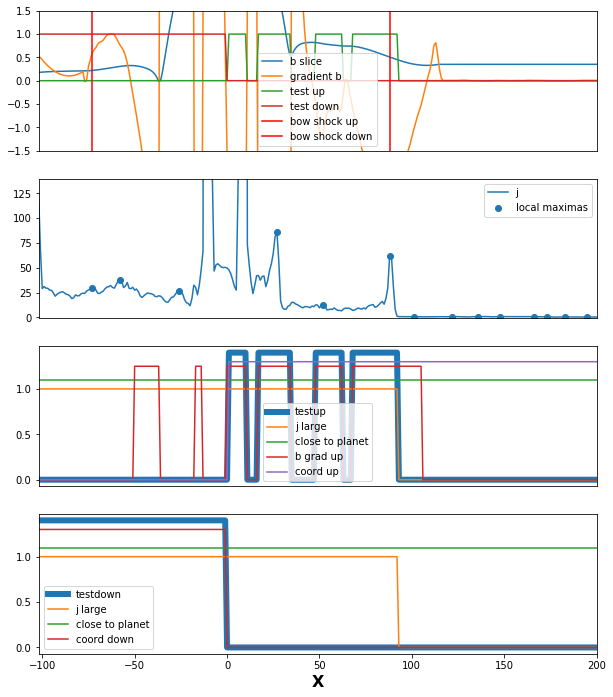

In [13]:
from matplotlib.gridspec    import GridSpec


plt.close('all')
plt.figure(figsize=(10, 18))
gs = GridSpec(6, 1)

axe = plt.subplot(gs[0])
axe.plot(coord, b_slice/150, label='b slice')
axe.plot(coord, np.gradient(b_slice), label='gradient b')
axe.plot(coord, test_up, label='test up')
axe.plot(coord, test_down, label='test down')
axe.set_ylim([-1.5,1.5])
axe.axvline(coord_bow_shock_up   , color='red', label="bow shock up")
axe.axvline(coord_bow_shock_down , color='red', label="bow shock down")
axe.set_xlim([min(coord), abs(min(coord))])
if str_coord == 'X':
    axe.set_xlim([min(coord), 200])
axe.get_xaxis().set_visible(False)
axe.legend()

axe = plt.subplot(gs[1], sharex=axe)
axe.plot(coord, j_slice , label='j')
plt.scatter(coord[maximums], j_slice[maximums], label='local maximas')
axe.set_ylim([-1,8*np.mean(j_slice)])
axe.get_xaxis().set_visible(False)
axe.legend()

axe = plt.subplot(gs[2], sharex=axe)
axe.plot(coord, 1.4*test_up, label='testup', linewidth=6)
axe.plot(coord, 1.0*test_j_large         , label='j large')
axe.plot(coord, 1.1*test_close_to_planet , label='close to planet')
if str_coord == 'X':
    axe.plot(coord, 1.25*test_b_grad_up       , label='b grad up')
axe.plot(coord, 1.3*test_coord_up        , label='coord up')
axe.get_xaxis().set_visible(False)
axe.legend()

axe = plt.subplot(gs[3], sharex=axe)
axe.plot(coord, 1.4*test_down, label='testdown', linewidth=6)
axe.plot(coord, 1.0*test_j_large         , label='j large')
axe.plot(coord, 1.1*test_close_to_planet , label='close to planet')
axe.plot(coord, 1.3*test_coord_down      , label='coord down')
axe.set_xlabel(str_coord, weight='bold', fontsize=16)
axe.legend()

plt.show()
if not(loop):
    plt.show()

In [14]:
len(coord)

1502

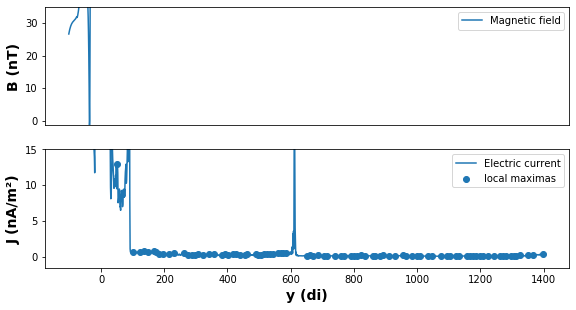

In [15]:
#thesis plot

plt.close('all')
plt.figure()
gs = GridSpec(2, 1)

axe = plt.subplot(gs[0])
axe.plot(coord, b_slice, label='Magnetic field')
axe.set_ylabel('B (nT)', weight='bold', fontsize='14')
axe.set_xlabel('x (di)', weight='bold', fontsize='14')
axe.set_ylim([-1.5,35])
axe.get_xaxis().set_visible(False)
axe.legend()

axe = plt.subplot(gs[1])
axe.plot(coord, j_slice, label='Electric current')
plt.scatter(coord[maximums], j_slice[maximums], label='local maximas')
axe.set_ylabel('J (nA/m²)', weight='bold', fontsize='14')
axe.set_xlabel('y (di)', weight='bold', fontsize='14')
axe.set_ylim([-1.5,15])
# axe.axvline(coord_bow_shock_up   , color='red', label="bow shock up")
# axe.axvline(coord_bow_shock_down , color='red', label="bow shock down")
# axe.set_xlim([min(coord), abs(min(coord))])
axe.legend()

In [16]:
# plt.plot(x[35:50], np.gradient(b_slice)[35:50])
# plt.axvline(coord_bow_shock_up   , color='red', label="bow shock up")

##### magnetopause

In [17]:
# When the magnetopause is misplaced, these next few cells should help understand why
dl = 2

str_coord='Z'


if (str_coord=='X'):
    coord = x
    slice_x = slice(None)
    slice_y = slice(ny0-dl, ny0+dl)
    slice_z = slice(nz0-dl, nz0+dl)
    slices = (slice_x, slice_y, slice_z)

    #Values for x are higher, because the shock takes the solar wind head-on
    #Dividing b_slice by 2 allows to use the same test for all coords.
    b_slice = np.sqrt( Bx[slices]**2
                      +By[slices]**2
                      +Bz[slices]**2 ).mean(axis=(1, 2))
    j_slice = np.sqrt(sum([ji**2 for ji in MD.J(B, slices)])).mean(axis=(1, 2))/2
    jx_slice = abs(MD.Jx(B, slices)).mean(axis=(1, 2))
    jy_slice = abs(MD.Jy(B, slices)).mean(axis=(1, 2))
    jz_slice = abs(MD.Jz(B, slices)).mean(axis=(1, 2))
    v_slice = np.sqrt( Vx[slices]**2
                      +Vy[slices]**2
                      +Vz[slices]**2 ).mean(axis=(1, 2))/2
    n_slice = N[slices].mean(axis=(1, 2))

if (str_coord=='Y'):
    coord = y
    gstep_coord = abs(np.mean(coord[1:] - coord[:-1]))
    slice_x = slice(nx0-dl, nx0+dl)
    slice_y = slice(None)
    slice_z = slice(nz0-dl, nz0+dl)
    slices = (slice_x, slice_y, slice_z)

    b_slice = np.sqrt( Bx[slices]**2
                      +By[slices]**2
                      +Bz[slices]**2 ).mean(axis=(0, 2))
    j_slice = np.sqrt(sum([ji**2 for ji in MD.J(B, slices)])).mean(axis=(0, 2))
    jx_slice = abs(MD.Jx(B, slices)).mean(axis=(0, 2))
    jy_slice = abs(MD.Jy(B, slices)).mean(axis=(0, 2))
    jz_slice = abs(MD.Jz(B, slices)).mean(axis=(0, 2))    
    v_slice = np.sqrt( Vx[slices]**2
                      +Vy[slices]**2
                      +Vz[slices]**2 ).mean(axis=(0, 2))
    n_slice = N[slices].mean(axis=(0, 2))

if (str_coord=='Z'):
    coord = z
    gstep_coord = abs(np.mean(coord[1:] - coord[:-1]))
    slice_x = slice(nx0-dl, nx0+dl)
    slice_y = slice(ny0-dl, ny0+dl)
    slice_z = slice(None)
    slices = (slice_x, slice_y, slice_z)

    b_slice = np.sqrt( Bx[slices]**2
                      +By[slices]**2
                      +Bz[slices]**2 ).mean(axis=(0, 1))
    j_slice = np.sqrt(sum([ji**2 for ji in MD.J(B, slices)])).mean(axis=(0, 1))
    jx_slice = abs(MD.Jx(B, slices)).mean(axis=(0, 1))
    jy_slice = abs(MD.Jy(B, slices)).mean(axis=(0, 1))
    jz_slice = abs(MD.Jz(B, slices)).mean(axis=(0, 1))    

    v_slice = np.sqrt( Vx[slices]**2
                      +Vy[slices]**2
                      +Vz[slices]**2 ).mean(axis=(0, 1))
    n_slice = N[slices].mean(axis=(0, 1))


In [18]:
n_slice = savgol_filter(n_slice, 51, 3)

test_planet = (15 < abs(coord)) & (abs(coord) < 80)
test_coord_up  = (coord > 0)
test_coord_down  = (coord < 0)
test_up   = test_coord_up & test_planet
test_down = test_coord_down & test_planet
test_grad_n_up   = (np.gradient(n_slice) > 0.1*max(np.gradient(n_slice))) & test_coord_up
test_grad_n_down = (np.gradient(n_slice) < 0.1*min(np.gradient(n_slice))) & test_coord_down

maximums = signal.argrelextrema(j_slice, np.greater, order=4)

if str_coord=='X':
    #This next line may be convoluted for nothing
    #Try: j_max_local_map_up = max(j_slice[test_up])
    j_max_local_max_up = max(MD.intersection(j_slice[maximums], j_slice[test_up]))
    i_m_up = MD.aplatir(np.where(j_slice == j_max_local_max_up))
    coord_magnetopause_up = coord[i_m_up]
    coord_magnetopause_down = 0
elif (str_coord == 'Y'):
    i_m_up = MD.give_center_of_multiple_ones(test_grad_n_up)
    coord_magnetopause_up = coord[i_m_up]
    i_m_down = MD.give_center_of_multiple_ones(test_grad_n_down)
    coord_magnetopause_down = coord[i_m_down]
#     j_max_local_max_up = MD.second_largest(j_slice, MD.intersection(j_slice[maximums], j_slice[test_up]))
#     i_m_up = MD.aplatir(np.where(j_slice == j_max_local_max_up))
#     coord_magnetopause_up = coord[i_m_up]
#     j_max_local_max_down = MD.second_largest(j_slice, MD.intersection(j_slice[maximums], j_slice[test_down]))
#     i_m_down = MD.aplatir(np.where(j_slice == j_max_local_max_down))
#     coord_magnetopause_down = coord[i_m_down]
elif (str_coord == 'Z'):
    j_max_local_max_up = max(MD.intersection(j_slice[maximums], j_slice[test_up]))
    i_m_up = MD.aplatir(np.where(j_slice == j_max_local_max_up))
    coord_magnetopause_up = coord[i_m_up]

    j_max_local_max_down = max(MD.intersection(j_slice[maximums], j_slice[test_down]))
    i_m_down = MD.aplatir(np.where(j_slice == j_max_local_max_down))
    coord_magnetopause_down = coord[i_m_down]



print(coord_magnetopause_up)
print(coord_magnetopause_down)

40.0
-48.0


In [19]:
# print([(i, test) for (i, test) in enumerate(test_grad_n_down & test_coord_down & test_planet)])
# give_center_of_multiple_ones(test_grad_n_down & test_coord_down & test_planet)

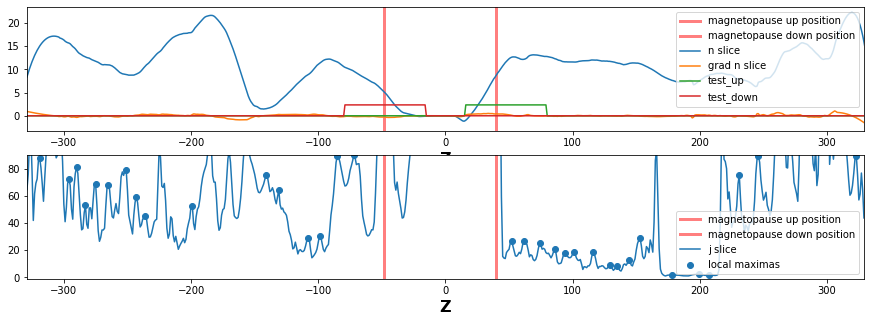

In [20]:
plt.close('all')
plt.figure(figsize=(15, 5))
gs = GridSpec(2, 1)

axe = plt.subplot(gs[0])
axe.set_xlabel(str_coord, weight='bold', fontsize=16)
axe.axvline(coord_magnetopause_up   , color='red', linewidth=3, alpha=0.5, label="magnetopause up position")
axe.axvline(coord_magnetopause_down , color='red', linewidth=3, alpha=0.5, label="magnetopause down position")
axe.plot(coord, n_slice, label='n slice')
axe.plot(coord, np.gradient(n_slice), label = 'grad n slice')
if str_coord == 'Y':
    axe.plot(coord, 0.1*axe.get_ylim()[1]*test_grad_n_up, label='test_grad_n_up')
    axe.plot(coord, 0.1*axe.get_ylim()[1]*test_grad_n_down, label='test_grad_n_down')
else:
    axe.plot(coord, 0.1*axe.get_ylim()[1]*test_up, label='test_up')
    axe.plot(coord, 0.1*axe.get_ylim()[1]*test_down, label='test_down')    
axe.set_xlim([min(coord), abs(min(coord))])
# axe.set_xlim([-100, 100])
axe.legend()

axe = plt.subplot(gs[1], sharex=axe)
axe.set_xlabel(str_coord, weight='bold', fontsize=16)
axe.axvline(coord_magnetopause_up   , color='red', linewidth=3, alpha=0.5, label="magnetopause up position")
axe.axvline(coord_magnetopause_down , color='red', linewidth=3, alpha=0.5, label="magnetopause down position")
axe.plot(coord, j_slice, label='j slice')
axe.scatter(coord[maximums], j_slice[maximums], label='local maximas')
ymax = 90 #0.1*np.nanmax(j_slice)
axe.set_ylim([-1, ymax])
# axe.plot(coord, 1000*np.gradient(n_slice), label = '1000*grad n slice')
# axe.plot(coord, 0.5*ymax*test_grad_n_up, label='strong up gradient')
# axe.plot(coord, 0.5*ymax*test_grad_n_down, label='strong down gradient')
axe.legend()


if not(loop):
    plt.show()

##### IP shock

In [21]:
coord = x
slice_x = slice(None)
slice_y = slice(dl, 3*dl)
slice_z = slice(dl, 3*dl)
slices = (slice_x, slice_y, slice_z)

v_slice = np.sqrt( Vx[slices]**2
                  +Vy[slices]**2
                  +Vz[slices]**2 ).mean(axis=(1, 2))/2
n_slice = N[slices].mean(axis=(1, 2))

In [22]:
grad_n = np.gradient(n_slice)
grad_v = np.gradient(v_slice)

In [23]:
ix_ip_shock = np.where(grad_v == np.nanmax(grad_v))
x_ip_shock = coord[ix_ip_shock]

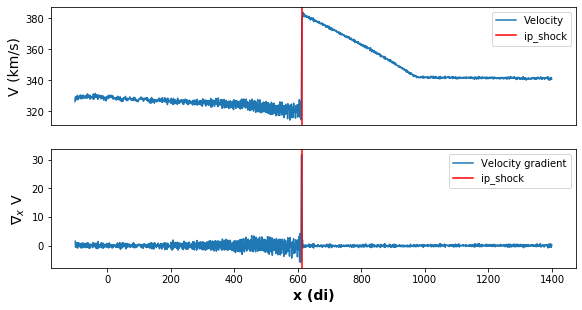

In [24]:
plt.close('all')
plt.figure()
gs = GridSpec(2, 1)

axe = plt.subplot(gs[0])
axe.plot(coord, v_slice, label='Velocity')
axe.set_ylabel('V (km/s)', fontsize='14')
axe.axvline(coord[ix_ip_shock], color='red', label="ip_shock")
axe.get_xaxis().set_visible(False)
axe.legend()

axe = plt.subplot(gs[1], sharex=axe)
axe.plot(coord, grad_v, label='Velocity gradient')
axe.set_ylabel(r'$\nabla_x$ V', fontsize='14')
axe.set_xlabel('x (di)', weight='bold', fontsize='14')
axe.axvline(coord[ix_ip_shock], color='red', label="ip_shock")
axe.legend()


if not(loop):

    plt.show()

##### MC leading edge

In [25]:
coord = x
slice_x = slice(None)
slice_y = slice(dl, 3*dl)
slice_z = slice(dl, 3*dl)
slices = (slice_x, slice_y, slice_z)

from scipy.signal import savgol_filter

b_slice = np.sqrt( Bx[slices]**2
                  +By[slices]**2
                  +Bz[slices]**2 ).mean(axis=(1, 2))/2
b_slice = savgol_filter(b_slice, 51, 3)
j_slice = np.sqrt(sum([ji**2 for ji in MD.J(B, slices)])).mean(axis=(1, 2))
v_slice = np.sqrt( Vx[slices]**2
                  +Vy[slices]**2
                  +Vz[slices]**2 ).mean(axis=(1, 2))/2
#For some reason, savgol doesn't always converge,
#this way of smoothing is a nice workaround
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
v_slice = smooth(v_slice, 51)
n_slice = N[slices].mean(axis=(1, 2))
n_slice = savgol_filter(n_slice, 51, 3)

grad_n = np.gradient(n_slice)
# grad_v = np.gradient(v_slice)
grad_b = np.gradient(b_slice)

In [26]:
test_grad_n = grad_n < -1*np.nanmean(abs(grad_n))
test_grad_b = grad_b > 1*np.nanmean(abs(grad_b))
test_non_absurd = (abs(coord) < 800) & (abs(coord - x_ip_shock) > 45)
test_le = test_grad_n & test_grad_b & test_non_absurd #& test_grad_v

In [27]:
try:
    ix_mc_leading_edge = np.where(j_slice == np.nanmax(j_slice[np.where(test_le)]))
    x_mc_leading_edge = x[ix_mc_leading_edge]
except ValueError:
    x_mc_leading_edge = np.nan

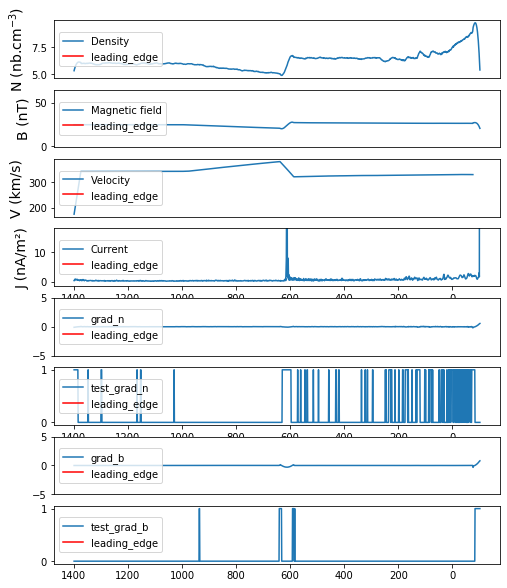

In [28]:
plt.close('all')
plt.figure(figsize=(8, 10))
gs = GridSpec(8, 1)

axe = plt.subplot(gs[0])
axe.plot(coord, n_slice, label='Density')
axe.set_ylabel(r'N (nb.cm$^{-3}$)', fontsize='14')
axe.axvline(x_mc_leading_edge, color='red', label="leading_edge")
axe.get_xaxis().set_visible(False)
axe.invert_xaxis()
axe.legend(loc='center left')

axe = plt.subplot(gs[1], sharex=axe)
axe.plot(coord, b_slice, label='Magnetic field')
axe.axvline(x_mc_leading_edge, color='red', label="leading_edge")
axe.set_ylim([-1.5,65])
axe.set_ylabel('B (nT)', fontsize='14')
axe.get_xaxis().set_visible(False)
axe.legend(loc='center left')

axe = plt.subplot(gs[2], sharex=axe)
axe.plot(coord, v_slice, label='Velocity')
axe.axvline(x_mc_leading_edge, color='red', label="leading_edge")
axe.set_ylabel('V (km/s)', fontsize='14')
axe.get_xaxis().set_visible(False)
axe.legend(loc='center left')

axe = plt.subplot(gs[3], sharex=axe)
axe.plot(coord, j_slice, label='Current')
axe.axvline(x_mc_leading_edge, color='red', label="leading_edge")
axe.set_ylim([-1.5,18])
axe.set_ylabel('J (nA/m²)', fontsize='14')
axe.legend(loc='center left')

axe = plt.subplot(gs[4], sharex=axe)
axe.plot(coord, grad_n, label='grad_n')
axe.axvline(x_mc_leading_edge, color='red', label="leading_edge")
axe.set_ylim([-5,5])
axe.get_xaxis().set_visible(False)
axe.legend(loc='center left')

axe = plt.subplot(gs[5], sharex=axe)
axe.plot(coord, test_grad_n, label='test_grad_n')
axe.axvline(x_mc_leading_edge, color='red', label="leading_edge")
axe.legend(loc='center left')

axe = plt.subplot(gs[6], sharex=axe)
axe.plot(coord, grad_b, label='grad_b')
axe.axvline(x_mc_leading_edge, color='red', label="leading_edge")
axe.set_ylim([-5,5])
axe.get_xaxis().set_visible(False)
axe.legend(loc='center left')

axe = plt.subplot(gs[7], sharex=axe)
axe.plot(coord, test_grad_b, label='test_grad_b')
axe.axvline(x_mc_leading_edge, color='red', label="leading_edge")
axe.legend(loc='center left')

# axe = plt.subplot(gs[8], sharex=axe)
# axe.plot(coord, grad_v)
# axe.axvline(x_mc_leading_edge, color='red', label="leading_edge")
# axe.set_ylim([-5,5])
# axe.set_ylabel(r'$\nabla_x$ B (nT)', fontsize='14')
# axe.get_xaxis().set_visible(False)
# axe.legend(loc='center left')

# axe = plt.subplot(gs[9], sharex=axe)
# axe.plot(coord, test_grad_v, label='test_grad_v')
# axe.axvline(x_mc_leading_edge, color='red', label="leading_edge")
# axe.legend(loc='center left')


if not(loop):

    plt.show()

### Compute global geometry & shock normals

In [29]:
# Locate bow shock and magnetopause    

x_bow_shock, x_magnetopause, y_bow_shock_up, y_bow_shock_down, y_magnetopause_up, y_magnetopause_down, z_bow_shock_up, z_bow_shock_down, z_magnetopause_up, z_magnetopause_down = MD.compute_global_geometry(B, N, V, metadata, time)

boxes = MD.create_boxes_dictionary()

x_ip_shock = MD.find_ip_shock(V, metadata, time)
x_mc_leading_edge = MD.find_mc_leading_edge(B, N, metadata, time)

In [30]:
chances = [1, 2, 3, 4]

while len(chances)>0:
    chances.pop()
    print(f"{len(chances)} chances left to compute boundaries")

    global_geometry = { 'x_bow_shock': x_bow_shock, 'x_magnetopause': x_magnetopause,
                        'y_bow_shock_up': y_bow_shock_up, 'y_bow_shock_down': y_bow_shock_down,
                        'y_magnetopause_up': y_magnetopause_up, 'y_magnetopause_down': y_magnetopause_down,
                        'z_bow_shock_up': z_bow_shock_up, 'z_bow_shock_down': z_bow_shock_down, 
                        'z_magnetopause_up': z_magnetopause_up, 'z_magnetopause_down': z_magnetopause_down,
                        'x_ip_shock': x_ip_shock, 'x_mc_leading_edge': x_mc_leading_edge }

    number_of_absurdities = 0
    for entry in global_geometry:
        absurdity = MD.check_for_absurdities(path_json, entry, time, global_geometry[entry])
        if not(absurdity):
            print("""Absurdities are not defined. This is either because no json_file exists yet, or because
                     this is the first time dump""")
            break
        if absurdity['absurd']:
            number_of_absurdities = number_of_absurdities + 1

            if absurdity['entry'] == 'x_bow_shock':
                x_bow_shock, _, _, _, _, _, _, _, _, _ = MD.compute_global_geometry(B, N, V, metadata, time, absurdity)
                print(f"New value for {absurdity['entry']} is {x_bow_shock}")
            if absurdity['entry'] == 'x_magnetopause':
                _, x_magnetopause, _, _, _, _, _, _, _, _ = MD.compute_global_geometry(B, N, V, metadata, time, absurdity)
                print(f"New value for {absurdity['entry']} is {x_magnetopause}")
            if absurdity['entry'] == 'y_bow_shock_up':
                _, _, y_bow_shock_up, _, _, _, _, _, _, _ = MD.compute_global_geometry(B, N, V, metadata, time, absurdity)
                print(f"New value for {absurdity['entry']} is {y_bow_shock_up}")
            if absurdity['entry'] == 'y_bow_shock_down':
                _, _, _,  y_bow_shock_down, _, _, _, _, _, _ = MD.compute_global_geometry(B, N, V, metadata, time, absurdity)
                print(f"New value for {absurdity['entry']} is {y_bow_shock_down}")
            if absurdity['entry'] == 'y_magnetopause_up':
                _, _, _, _, y_magnetopause_up, _, _, _, _, _ = MD.compute_global_geometry(B, N, V, metadata, time, absurdity)
                print(f"New value for {absurdity['entry']} is {y_magnetopause_up}")
            if absurdity['entry'] == 'y_magnetopause_down':
                _, _, _, _, _, y_magnetopause_down, _, _, _, _ = MD.compute_global_geometry(B, N, V, metadata, time, absurdity)
                print(f"New value for {absurdity['entry']} is {y_magnetopause_down}")
            if absurdity['entry'] == 'z_bow_shock_up':
                _, _, _, _, _, _, z_bow_shock_up, _, _, _ = MD.compute_global_geometry(B, N, V, metadata, time, absurdity)
                print(f"New value for {absurdity['entry']} is {z_bow_shock_up}")
            if absurdity['entry'] == 'z_bow_shock_down':
                _, _, _, _, _, _, _, z_bow_shock_down, _, _ = MD.compute_global_geometry(B, N, V, metadata, time, absurdity)
                print(f"New value for {absurdity['entry']} is {z_bow_shock_down}")            
            if absurdity['entry'] == 'z_magnetopause_up':
                _, _, _, _, _, _, _, _, z_magnetopause_up, _ = MD.compute_global_geometry(B, N, V, metadata, time, absurdity)
                print(f"New value for {absurdity['entry']} is {z_magnetopause_up}")
            if absurdity['entry'] == 'z_magnetopause_down':
                _, _, _, _, _, _, _, _, _, z_magnetopause_down = MD.compute_global_geometry(B, N, V, metadata, time, absurdity)
                print(f"New value for {absurdity['entry']} is {z_magnetopause_down}")
                    
            if absurdity['entry'] == 'x_ip_shock':
                x_ip_shock = MD.x_is.item()
                print("Be careful, changes of x_ip_shock have not been implemented, nothing changed")
            if absurdity['entry'] ==  'x_mc_leading_edge':
                x_mc_leading_edge = MD.find_mc_leading_edge(B, N, metadata, time, absurdity=absurdity).item()
                print(f"New value for {absurdity['entry']} is {x_mc_leading_edge}")
        
    print(f"there were {number_of_absurdities} absurdities in the computation of the global geometry")
    if number_of_absurdities==0:
        print("everything seems alright, let's roll on")
        break
if len(chances)==0:
    print(f"time dump {time_label} seems to have some issues. Check the positions of the boundaries!")

3 chances left to compute boundaries
This is absurd, z_bow_shock_up was located at 156.0 at time t00270 
                  and now it would be at 40.0 at time 00280!
z_bow_shock_up was weirdly placed, let us try to correct that
New value for z_bow_shock_up is 251.0
This is absurd, z_bow_shock_down was located at -246.0 at time t00270 
                  and now it would be at -47.0 at time 00280!
z_bow_shock_down was weirdly placed, let us try to correct that
New value for z_bow_shock_down is -319.0
there were 2 absurdities in the computation of the global geometry
2 chances left to compute boundaries
there were 0 absurdities in the computation of the global geometry
everything seems alright, let's roll on


In [31]:
global_geometry

{'x_bow_shock': 88.0,
 'x_magnetopause': 27.0,
 'y_bow_shock_up': 157.0,
 'y_bow_shock_down': -162.0,
 'y_magnetopause_up': 42.0,
 'y_magnetopause_down': -44.0,
 'z_bow_shock_up': 251.0,
 'z_bow_shock_down': -319.0,
 'z_magnetopause_up': 40.0,
 'z_magnetopause_down': -47.0,
 'x_ip_shock': array([nan]),
 'x_mc_leading_edge': array([nan])}

In [32]:
# #This is ill-defined. The local "upstream" of each box should be defined by following velocity stream lines

# normales = {}

# for box in boxes:
#     loc = boxes[box]['center']
#     origin, vector = MD.bow_shock_normale(loc, B, N, V)
#     print(f"normale for {box} box is {vector} at origin {origin}")
#     normales.update({  f'{box}': {'origin': origin,
#                                   'vector': vector}  })

In [33]:
# for box in boxes:
#     loc = boxes[box]['center']
#     dict_params = MD.calculate_bow_shock_parameters(loc, B, N, V, T)
#     print(MD.color.BOLD + f"shock params for {box}:" + MD.color.END)        
#     for param in dict_params:
#           print(f'{param}: {dict_params[param]:0.2g}')
          


In [34]:
# normales_xy = {}

# for box in ['nose', 'yup', 'ydown']:
#     loc = boxes[box]['center']
#     origin, vector = MD.bow_shock_normale(loc, B, N, V)
#     print(f"normale for {box} box is {vector} at origin {origin}")
#     normales_xy.update({  f'{box}': {'origin': origin,
#                                      'vector': vector}  })
    
# normales_xz = {}

# for box in ['nose', 'zup', 'zdown']:
#     loc = boxes[box]['center']
#     origin, vector = MD.bow_shock_normale(loc, B, N, V)
#     print(f"normale for {box} box is {vector} at origin {origin}")
#     normales_xz.update({  f'{box}': {'origin': origin,
#                                      'vector': vector}  })

### Actual plots

In [35]:
xmin = min(x)
xmax = 3*abs(xmin)   #Most of the length in the x direction is used to give space for the sheath to form
                     #It is not really interesting
# zoom = (xmin, xmax, min(y), max(y), min(z), max(z))
zoom = (-100, 100, -200, 200, -225, 225)

# lw = 2*np.sqrt(Bx.transpose()**2 + Bj.transpose()**2) / np.mean(A)

#### Magnetic field

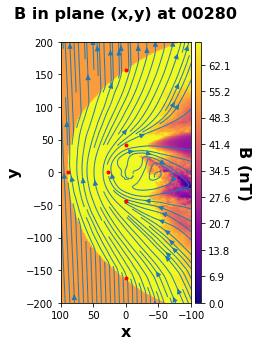

In [36]:
mag_B = np.sqrt( Bx[:,:,nz0]**2
                +By[:,:,nz0]**2
                +Bz[:,:,nz0]**2 )

magplot = MD.plot_colormap(mag_B, title = f'B in plane (x,y) at {time}', label = 'B (nT)', plane = 'xy',
                 ratio_max_to_med = 1.4, with_dots = True, normales = None, loop = loop,
                 save_dir = storing_directory, t_label = time_label,
                 zoom = zoom, density = 7.5, 
                 streamplot = True, Bx = Bx[:,:,nz0], Bj = By[:,:,nz0])

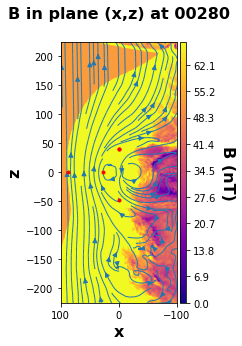

In [37]:
mag_B = np.sqrt( Bx[:,ny0,:]**2
                +By[:,ny0,:]**2
                +Bz[:,ny0,:]**2 )

MD.plot_colormap(mag_B, f'B in plane (x,z) at {time}', 'B (nT)', 'xz',
                 ratio_max_to_med = 1.4, with_dots = True, normales = None, loop = loop,
                 save_dir = storing_directory, t_label = time_label,
                 zoom = zoom, density = 5.5,
                 streamplot = True, Bx = Bx[:,ny0,:], Bj = Bz[:,ny0,:])

#### Plasma density

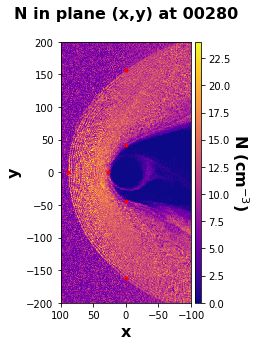

In [38]:
MD.plot_colormap(N[:,:,nz0], f'N in plane (x,y) at {time}', r'N (cm$^{-3}$)', 'xy',
                 with_dots = True, normales = None, loop = loop,
                 save_dir = storing_directory, t_label = time_label,
                 zoom = zoom)

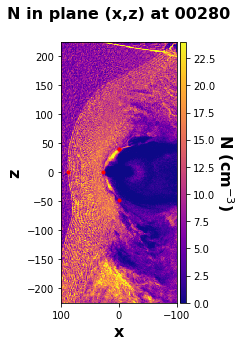

In [39]:
MD.plot_colormap(N[:,ny0,:], f'N in plane (x,z) at {time}', r'N (cm$^{-3}$)', 'xz',
                 with_dots = True, normales = None, loop = loop,
                 save_dir = storing_directory, t_label = time_label,
                 zoom = zoom)

#### Current

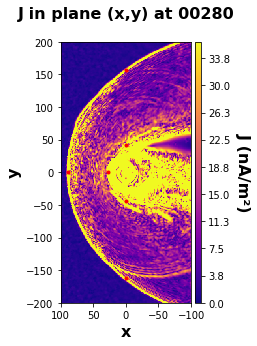

In [40]:
slice_x = slice(None)
slice_y = slice(None)
slice_z = slice(nz0-1, nz0+1)
slices = (slice_x, slice_y, slice_z)

mag_J = np.sqrt(MD.Jx(B, slices)[:,:,1]**2 + MD.Jy(B, slices)[:,:,1]**2 + MD.Jz(B, slices)[:,:,1]**2)

MD.plot_colormap(mag_J, f'J in plane (x,y) at {time}', 'J (nA/m²)', 'xy', ratio_max_to_med = 80,
                 with_dots = True, normales = None, loop = loop,
                 save_dir = storing_directory, t_label = time_label,
                 zoom = zoom)

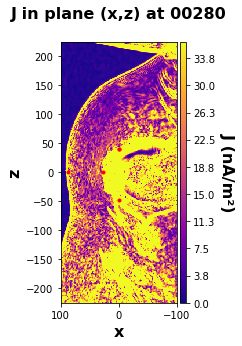

In [41]:
slice_x = slice(None)
slice_y = slice(ny0-1, ny0+1)
slice_z = slice(None)
slices = (slice_x, slice_y, slice_z)

mag_J = np.sqrt(MD.Jx(B, slices)[:,1,:]**2 + MD.Jy(B, slices)[:,1,:]**2 + MD.Jz(B, slices)[:,1,:]**2)

MD.plot_colormap(mag_J, f'J in plane (x,z) at {time}', 'J (nA/m²)', 'xz', ratio_max_to_med = 80,
                 with_dots = True, normales = None, loop = loop,
                 save_dir = storing_directory, t_label = time_label,
                 zoom = zoom)

#### Velocity

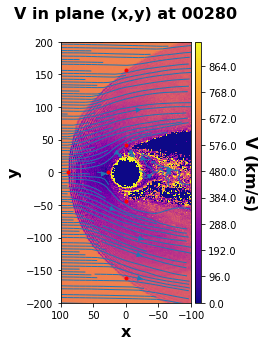

In [42]:
mag_V = np.sqrt( Vx[:,:,nz0]**2
                +Vy[:,:,nz0]**2
                +Vz[:,:,nz0]**2 )

np.nan_to_num(mag_V, 0)

magplot = MD.plot_colormap(mag_V, title = f'V in plane (x,y) at {time}', label = 'V (km/s)', plane = 'xy',
                 ratio_max_to_med = 1.4, with_dots = True, normales = None, loop = loop,
                 save_dir = storing_directory, t_label = time_label,
                 zoom = zoom, density = 5.5, 
                 streamplot = True, Bx = Vx[:,:,nz0], Bj = Vy[:,:,nz0])

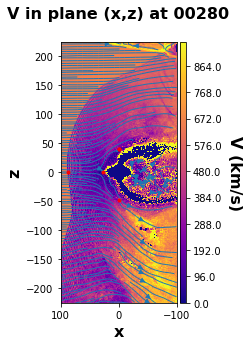

In [43]:
mag_V = np.sqrt( Vx[:,ny0,:]**2
                +Vy[:,ny0,:]**2
                +Vz[:,ny0,:]**2 )

np.nan_to_num(mag_V, 0)

magplot = MD.plot_colormap(mag_V, title = f'V in plane (x,z) at {time}', label = 'V (km/s)', plane = 'xz',
                 ratio_max_to_med = 1.4, with_dots = True, normales = None, loop = loop,
                 save_dir = storing_directory, t_label = time_label,
                 zoom = zoom, density = 5.5, 
                 streamplot = True, Bx = Vx[:,ny0,:], Bj = Vz[:,ny0,:])

#### Extra plots

In [44]:
zoom = (0, 60, -100, 100, -100, 100)

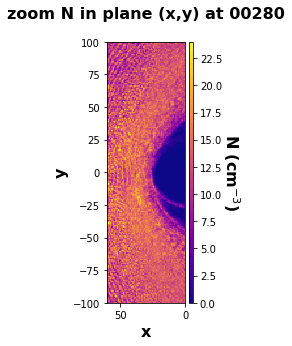

In [45]:
MD.plot_colormap(N[:,:,nz0], f'zoom N in plane (x,y) at {time}', r'N (cm$^{-3}$)', 'xy',
                 with_dots = False, normales = None, loop = loop,
                 save_dir = storing_directory, t_label = time_label,
                 zoom = zoom)

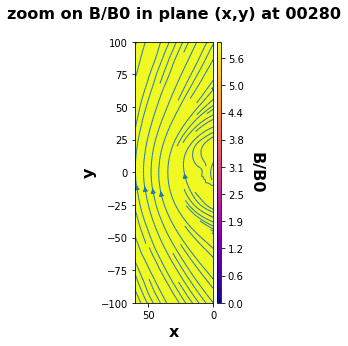

In [46]:
mag_B = np.sqrt( Bx[:,:,nz0]**2
                +By[:,:,nz0]**2
                +Bz[:,:,nz0]**2 )

magplot = MD.plot_colormap(mag_B/10, title = f'zoom on B/B0 in plane (x,y) at {time}', label = 'B/B0', plane = 'xy',
                 ratio_max_to_med = 1.4, with_dots = False, normales = None, loop = loop,
                 save_dir = storing_directory, t_label = time_label,
                 zoom = zoom, density = 11, 
                 streamplot = True, Bx = Bx[:,:,nz0], Bj = By[:,:,nz0])

In [47]:
y_bow_shock_down

-162.0

In [48]:
zoom = (-100, x_bow_shock+15, y_bow_shock_down-65, y_bow_shock_up+65, z_bow_shock_down-65, z_bow_shock_up+65)

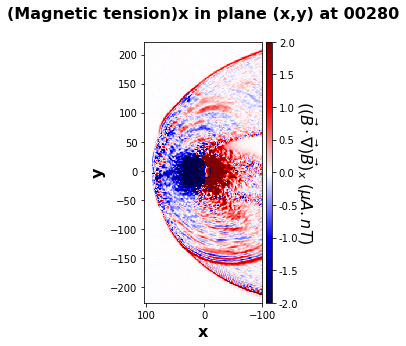

In [49]:
slice_x = slice(None)
slice_y = slice(None)
slice_z = slice(nz0-1, nz0+1)
slices = (slice_x, slice_y, slice_z)

J_plane_xy = MD.J(B, slices)
B_plane_xy = (Bx[slices], By[slices], Bz[slices])

JxB = MD.cross_product(J_plane_xy, B_plane_xy)
JxB_x = JxB[0][:,:,1]
JxB_y = JxB[1][:,:,1]
JxB_z = JxB[2][:,:,1]

MD.plot_colormap(JxB_x/1e3, title = f'(JxB)x in plane (x,y) at {time}',
                 label = r'$(\vec{J}\times\vec{B})_x \ (\mu A.nT)$', plane = 'xy',
                 ratio_max_to_med = 5e2, with_dots = False, normales = None, loop = loop,
                 save_dir = storing_directory, t_label = time_label,
                 zoom = zoom, map_color='seismic', min_value=-2, max_value=2)


MD.plot_colormap(JxB_y/1e3, title = f'(JxB)y in plane (x,y) at {time}',
                 label = r'$(\vec{J}\times\vec{B})_y \ (\mu A.nT)$', plane = 'xy',
                 ratio_max_to_med = 5e2, with_dots = False, normales = None, loop = loop,
                 save_dir = storing_directory, t_label = time_label,
                 zoom = zoom, map_color='seismic', min_value=-2, max_value=2)

Mag_tension = np.array(JxB) + np.gradient( MD.norm(B, slices)**2  / (2*MD.µ0 * cwp[0]*1e3) ) 
Mag_tension = Mag_tension[:,:,:,1]

MD.plot_colormap(Mag_tension[0]/1e3, title = f'(Magnetic tension)x in plane (x,y) at {time}',
                 label = r'$((\vec{B}\cdot\vec{\nabla})\vec{B})_x \ (\mu A.nT)$', plane = 'xy',
                 ratio_max_to_med = 5e2, with_dots = False, normales = None, loop = loop,
                 save_dir = storing_directory, t_label = time_label,
                 zoom = zoom, map_color='seismic', min_value=-2, max_value=2)

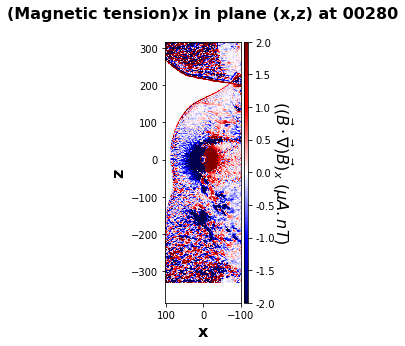

In [50]:
slice_x = slice(None)
slice_y = slice(ny0-1, ny0+1)
slice_z = slice(None)
slices = (slice_x, slice_y, slice_z)

J_plane_xz = MD.J(B, slices)
B_plane_xz = (Bx[slices], By[slices], Bz[slices])

JxB = MD.cross_product(J_plane_xz, B_plane_xz)
JxB_x = JxB[0][:,1,:]
JxB_y = JxB[1][:,1,:]
JxB_z = JxB[2][:,1,:]

MD.plot_colormap(JxB_x/1e3, title = f'(JxB)x in plane (x,z) at {time}',
                 label = r'$(\vec{J}\times\vec{B})_x \ (\mu A.nT)$', plane = 'xz',
                 ratio_max_to_med = 5e2, with_dots = False, normales = None, loop = loop,
                 save_dir = storing_directory, t_label = time_label,
                 zoom = zoom, map_color='seismic', min_value=-2, max_value=2)

MD.plot_colormap(JxB_z/1e3, title = f'(JxB)z in plane (x,z) at {time}',
                 label = r'$(\vec{J}\times\vec{B})_z \ (\mu A.nT)$', plane = 'xz',
                 ratio_max_to_med = 5e2, with_dots = False, normales = None, loop = loop,
                 save_dir = storing_directory, t_label = time_label,
                 zoom = zoom, map_color='seismic', min_value=-2, max_value=2)

Mag_tension = np.array(JxB) + np.gradient( MD.norm(B, slices)**2  / (2*MD.µ0 * cwp[0]*1e3) ) 
Mag_tension = Mag_tension[:,:,1,:]

MD.plot_colormap(Mag_tension[0]/1e3, title = f'(Magnetic tension)x in plane (x,z) at {time}',
                 label = r'$((\vec{B}\cdot\vec{\nabla})\vec{B})_x \ (\mu A.nT)$', plane = 'xz',
                 ratio_max_to_med = 5e2, with_dots = False, normales = None, loop = loop,
                 save_dir = storing_directory, t_label = time_label,
                 zoom = zoom, map_color='seismic', min_value=-2, max_value=2)

### Why Vz?

In [51]:
if not(loop):

    plt.close('all')
    plt.figure(figsize=(15, 12))
    gs = GridSpec(6, 1)

    axe = plt.subplot(gs[0])
    axe.plot(x, Bx[:,ny0,nz0], label='Bx')
    axe.plot(x, By[:,ny0,nz0], label='By')
    axe.plot(x, Bz[:,ny0,nz0], label='Bz')
    plt.legend(loc='center left')
    axe.get_xaxis().set_visible(False)
    axe.set_ylabel('Magnetic field (nT)')
    plt.gca().invert_xaxis()

    axe = plt.subplot(gs[1])
    axe.plot(x, Ex[:,ny0,nz0], label='Ex')
    axe.plot(x, Ey[:,ny0,nz0], label='Ey')
    axe.plot(x, Ez[:,ny0,nz0], label='Ez')
    plt.legend(loc='center left')
    axe.get_xaxis().set_visible(False)
    axe.set_ylabel('Electric field (mV/m)')
    plt.gca().invert_xaxis()

    axe = plt.subplot(gs[2], sharex=axe)
    axe.plot(x, Vx[:,ny0,nz0], label='Vx')
    axe.plot(x, Vy[:,ny0,nz0], label='Vy')
    axe.plot(x, Vz[:,ny0,nz0], label='Vz')
    plt.legend(loc='center left')
    axe.get_xaxis().set_visible(False)
    axe.set_ylabel('Velocity (km/s))')

    axe = plt.subplot(gs[3], sharex=axe)
    axe.plot(x, N[:,ny0,nz0] , label='N' )
    plt.legend(loc='center left')
    axe.get_xaxis().set_visible(False)
    axe.set_ylabel('Density (cc)')

    slice_x = slice(None)
    slice_y = slice(ny0-1, ny0+1)
    slice_z = slice(nz0-1, nz0+1)
    slices = (slice_x, slice_y, slice_z)

    axe = plt.subplot(gs[4], sharex=axe)
    axe.plot(x, MD.Jx(B, slices)[:,1,1], label='Jx')
    axe.plot(x, MD.Jy(B, slices)[:,1,1], label='Jy')
    axe.plot(x, MD.Jz(B, slices)[:,1,1], label='Jz')
    plt.legend(loc='center left')
    axe.get_xaxis().set_visible(False)
    axe.set_ylabel('Current (nA/m²))')


    #MD.cross_product(vector_1, vector_2, slice_=slice(None))

    J_slice = (MD.Jx(B, slices)[:,1,1], MD.Jy(B, slices)[:,1,1], MD.Jz(B, slices)[:,1,1])
    B_slice = (Bx[slices][:,1,1], By[slices][:,1,1], Bz[slices][:,1,1])

    JxB = [MD.j*MD.b * jxb for jxb in  MD.cross_product(J_slice, B_slice)]

    axe = plt.subplot(gs[5], sharex=axe)
    axe.plot(x, JxB[0], label='JxB_x')
    axe.plot(x, JxB[1], label='JxB_y')
    axe.plot(x, JxB[2], label='JxB_z')
    plt.legend(loc='center left')
    axe.set_ylabel('JxB (A.T / m²)')

    axe.set_xlim([400, 0])
    axe.set_xlabel(r'x (di)')

In [52]:
if not(loop):

    plt.close('all')
    plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 1)

    axe = plt.subplot(gs[0], sharex=axe)
    axe.plot(x, Vx[:,ny0,nz0], label='Vx')
    axe.plot(x, Vy[:,ny0,nz0], label='Vy')
    axe.plot(x, Vz[:,ny0,nz0], label='Vz')
    plt.legend(loc='center left')
    axe.get_xaxis().set_visible(False)
    axe.set_ylabel('Velocity (km/s))')

    axe = plt.subplot(gs[1], sharex=axe)
    axe.plot(x, JxB[0], label='JxB_x')
    axe.plot(x, JxB[1], label='JxB_y')
    axe.plot(x, JxB[2], label='JxB_z')
    plt.legend(loc='center left')
    axe.set_ylabel('JxB (A.T / m²)')

    axe.set_xlim([400, 0])
    axe.set_xlabel(r'x (di)')

    plt.show()

In [53]:
if not(loop):

    V_slice = (Vx[slices][:,1,1], Vy[slices][:,1,1], Vz[slices][:,1,1])
    B_slice = (Bx[slices][:,1,1], By[slices][:,1,1], Bz[slices][:,1,1])
    N_slice = N[slices][:,1,1]

    VxB = [MD.v*MD.b * vxb for vxb in  MD.cross_product(V_slice, B_slice)]

    JxB_qn = [MD.j*MD.b/(MD.qe*MD.n) * jxb / N_slice for jxb in  MD.cross_product(J_slice, B_slice)]


    plt.close('all')
    plt.figure(figsize=(15, 10))
    gs = GridSpec(4, 1)

    axe = plt.subplot(gs[0], sharex=axe)
    axe.plot(x, Ex[:,ny0,nz0], label='Ex')
    axe.plot(x, Ey[:,ny0,nz0], label='Ey')
    axe.plot(x, Ez[:,ny0,nz0], label='Ez')
    plt.legend(loc='center left')
    axe.get_xaxis().set_visible(False)
    axe.set_ylabel('Electric field (mV/m))')

    Ohm = [-np.array(VxB[i])+np.array(JxB_qn[i]) for i in range(0,3)]

    axe = plt.subplot(gs[1], sharex=axe)
    axe.plot(x, Ohm[0]/MD.e, label='Ohm_x')
    axe.plot(x, Ohm[1]/MD.e, label='Ohm_y')
    axe.plot(x, Ohm[2]/MD.e, label='Ohm_z')
    plt.legend(loc='center left')
    axe.set_ylabel('Ohm (mV/m))')

    axe = plt.subplot(gs[2], sharex=axe)
    axe.plot(x, Ez[:,ny0,nz0], label='Ez')
    axe.plot(x, Ohm[2]/MD.e, label='Ohm_z')
    axe.plot(x, -VxB[2]/MD.e, label='VxB_z')
    axe.plot(x, JxB_qn[2]/MD.e, label='JxB_qn_z')
    plt.legend(loc='center left')
    axe.set_ylabel('(mV/m))')

    axe = plt.subplot(gs[3], sharex=axe)
    axe.plot(x, Ex[:,ny0,nz0], label='Ex')
    axe.plot(x, Ohm[0]/MD.e, label='Ohm_x')
    axe.plot(x, -VxB[0]/MD.e, label='VxB_x')
    axe.plot(x, JxB_qn[0]/MD.e, label='JxB_qn_x')
    plt.legend(loc='center left')
    axe.set_ylabel('(mV/m))')

    axe.set_xlim([400, 0])
    axe.set_xlabel(r'x (di)')

In [54]:
if not(loop):

    axe = plt.figure(figsize=(15, 8))
    plt.plot(x, JxB_qn[2]/MD.e, label='JxB_qn_z')
    plt.legend(loc='center left')
    plt.ylabel('(mV/m))')
    plt.xlim([max(x), min(x)])
    plt.xlabel(r'x (di)')

    def integral(lower, upper, coord, vector):
        return(sum(vector[np.where(coord==lower)[0][0]:np.where(coord==upper)[0][0]]))

    xmin = min(x)+1
    int_JxB_z = [integral(xmin, xi, x, JxB_qn[2]/MD.e) for xi in x]

    axe = plt.figure(figsize=(15, 8))
    plt.plot(x, int_JxB_z, label='int_JxB_z')
    plt.legend(loc='center left')
    plt.ylabel('(mV))')
    plt.xlim([max(x), min(x)])
    plt.xlabel(r'x (di)')

    int_VxB_z = [integral(xmin, xi, x, VxB[2]/MD.e) for xi in x]

    axe = plt.figure(figsize=(15, 8))
    plt.plot(x, int_VxB_z, label='int_VxB_z')
    plt.legend(loc='center left')
    plt.ylabel('(mV))')
    plt.xlim([max(x), min(x)])
    plt.xlabel(r'x (di)')

In [55]:
if not(loop):

    axe = plt.figure(figsize=(15, 8))
    plt.plot(x, JxB_qn[0]/MD.e, label='JxB_qn_x')
    plt.legend(loc='center left')
    plt.ylabel('(mV/m))')
    plt.xlim([max(x), min(x)])
    plt.xlabel(r'x (di)')

    xmin = min(x)+1
    int_JxB_x = [integral(xmin, xi, x, JxB_qn[0]/MD.e) for xi in x]

    axe = plt.figure(figsize=(15, 8))
    plt.plot(x, int_JxB_x, label='int_JxB_x')
    plt.legend(loc='center left')
    plt.ylabel('(mV))')
    plt.xlim([max(x), min(x)])
    plt.xlabel(r'x (di)')

    int_VxB_x = [integral(xmin, xi, x, VxB[0]/MD.e) for xi in x]

    axe = plt.figure(figsize=(15, 8))
    plt.plot(x, int_VxB_x, label='int_VxB_x')
    plt.legend(loc='center left')
    plt.ylabel('(mV))')
    plt.xlim([max(x), min(x)])
    plt.xlabel(r'x (di)')

In [56]:
if not(loop):

    axe = plt.figure(figsize=(15, 8))
    plt.plot(x, Ex[:,ny0,nz0], label='Ex')
    plt.plot(x, Ohm[0]/MD.e, label='Ohm_x')
    # plt.plot(x, -VxB[0]/MD.e, label='VxB_x')
    plt.plot(x, JxB_qn[0]/MD.e, label='JxB_qn_x')
    plt.legend(loc='center left')
    plt.ylabel('(mV/m))')
    plt.xlim([400, 0])
    plt.xlabel(r'x (di)')

In [57]:
if not(loop):

    grad_B = MD.gradient(B, slices)
    grad_BxB = MD.cross_product(grad_B, (Bx[slices], By[slices], Bz[slices]))
    grad_BxB = [gradbxb[:, 1, 1] for gradbxb in grad_BxB]

    axe = plt.figure(figsize=(15, 8))
    plt.plot(x, grad_BxB[0], label='gradBxB_x')
    plt.plot(x, grad_BxB[1], label='gradBxB_y')
    plt.plot(x, grad_BxB[2], label='gradBxB_z')
    plt.legend(loc='center left')
    plt.ylabel('?')
    plt.xlim([400, 0])
    plt.xlabel(r'x (di)')

### Boxes

In [58]:
# %matplotlib notebook

if not(loop):
    MD.plot_boxes()

In [59]:
ixmax = MD.aplatir(np.where(x>=xmax))[0]
N_and_boxes = N[:ixmax, :, :].copy() #No need to plot the whole x_direction, it is mostly solar wind

boxes = MD.create_boxes_dictionary()

for box in boxes:   
    ixmax,ixmin,iymax,iymin,izmax,izmin = MD.construct_box_indexes(box,
                                                                   boxes[box]["coord_bow_shock"],
                                                                   boxes[box]['coord_magnetopause'])

    slices = (slice(ixmin, ixmax), slice(iymin, iymax), slice(izmin, izmax))    

    N_and_boxes[slices] = 0 #Put the density to zero in the boxes, so that they are easy to spot on a plot

In [60]:
# for box in boxes:   
    
#     origin = normales[box]['origin']
#     magnetosheath_half_width = abs(x_bow_shock-x_magnetopause)/2

#     loc_upstream = (origin[0]+2*magnetosheath_half_width, origin[1], origin[2])
#     xmin, ymin, zmin = loc_upstream[0]-MD.size_cubes/2, loc_upstream[1]-MD.size_cubes/2, loc_upstream[2]-MD.size_cubes/2
#     xmax, ymax, zmax = loc_upstream[0]+MD.size_cubes/2, loc_upstream[1]+MD.size_cubes/2, loc_upstream[2]+MD.size_cubes/2
#     ixmin, iymin, izmin = MD.convert_coord_to_indices((xmin, ymin, zmin))
#     ixmax, iymax, izmax = MD.convert_coord_to_indices((xmax, ymax, zmax))

#     slice_upstream = (slice(ixmin, ixmax), slice(iymin, iymax), slice(izmin, izmax)) 

#     N_and_boxes[slice_upstream] = np.max(N) #Put the density to max(N) in the boxes, so that they are easy to spot on a plot

In [61]:
if not(loop):
    
    %matplotlib notebook

    fig, ax = plt.subplots(1, 1)

    tracker = IndexTracker(ax, N_and_boxes, 'xy')

    fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
    plt.show()

## Generate relevant data

### Size of the magnetosheath

In [62]:
size_nose  = abs(  x_bow_shock      - x_magnetopause       )
size_yup   = abs(  y_bow_shock_up   - y_magnetopause_up    )
size_ydown = abs(  y_bow_shock_down - y_magnetopause_down  )
size_zup   = abs(  z_bow_shock_up   - z_magnetopause_up    )
size_zdown = abs(  z_bow_shock_down - z_magnetopause_down  )

### Data in cubes

In [63]:
B_upstream, B_nose, B_yup, B_ydown, B_zup, B_zdown = MD.compute_data_in_cubes(B, function1=MD.norm)

Bx_upstream, Bx_nose, Bx_yup, Bx_ydown, Bx_zup, Bx_zdown = MD.compute_data_in_cubes(Bx)
By_upstream, By_nose, By_yup, By_ydown, By_zup, By_zdown = MD.compute_data_in_cubes(By)
Bz_upstream, Bz_nose, Bz_yup, Bz_ydown, Bz_zup, Bz_zdown = MD.compute_data_in_cubes(Bz)

E_upstream, E_nose, E_yup, E_ydown, E_zup, E_zdown = MD.compute_data_in_cubes(E, function1=MD.norm)

Ex_upstream, Ex_nose, Ex_yup, Ex_ydown, Ex_zup, Ex_zdown = MD.compute_data_in_cubes(Ex)
Ey_upstream, Ey_nose, Ey_yup, Ey_ydown, Ey_zup, Ey_zdown = MD.compute_data_in_cubes(Ey)
Ez_upstream, Ez_nose, Ez_yup, Ez_ydown, Ez_zup, Ez_zdown = MD.compute_data_in_cubes(Ez)

N_upstream, N_nose, N_yup, N_ydown, N_zup, N_zdown = MD.compute_data_in_cubes(N)

T_upstream, T_nose, T_yup, T_ydown, T_zup, T_zdown = MD.compute_data_in_cubes(T)

V_upstream, V_nose, V_yup, V_ydown, V_zup, V_zdown = MD.compute_data_in_cubes(V, function1=MD.norm)

Vx_upstream, Vx_nose, Vx_yup, Vx_ydown, Vx_zup, Vx_zdown = MD.compute_data_in_cubes(Vx)
Vy_upstream, Vy_nose, Vy_yup, Vy_ydown, Vy_zup, Vy_zdown = MD.compute_data_in_cubes(Vy)
Vz_upstream, Vz_nose, Vz_yup, Vz_ydown, Vz_zup, Vz_zdown = MD.compute_data_in_cubes(Vz)

print("calculating J")
J_upstream, J_nose, J_yup, J_ydown, J_zup, J_zdown = MD.compute_data_in_cubes(data1=B, function1=MD.J)

Jx_upstream, Jx_nose, Jx_yup, Jx_ydown, Jx_zup, Jx_zdown = MD.compute_data_in_cubes(B, function1=MD.Jx)
Jy_upstream, Jy_nose, Jy_yup, Jy_ydown, Jy_zup, Jy_zdown = MD.compute_data_in_cubes(B, function1=MD.Jy)
Jz_upstream, Jz_nose, Jz_yup, Jz_ydown, Jz_zup, Jz_zdown = MD.compute_data_in_cubes(B, function1=MD.Jz)

JE_upstream, JE_nose, JE_yup, JE_ydown, JE_zup, JE_zdown = MD.compute_data_in_cubes(data1=B, data2=E,
                                                                                    function1=MD.J,
                                                                                    function_both=MD.dot_product)


JxB_upstream, JxB_nose, JxB_yup, JxB_ydown, JxB_zup, JxB_zdown = MD.compute_data_in_cubes(data1=B, data2=B,
                                                                                          function1=MD.J,
                                                                                          function_both=MD.cross_product)

calculating J


In [64]:
Mag_tension_dict = {}

for box in boxes:

    ind = MD.construct_box_indexes(box, boxes[box]["coord_bow_shock"],
                                        boxes[box]["coord_magnetopause"])

    slices = (slice(ind[1], ind[0]), slice(ind[3], ind[2]), slice(ind[5], ind[4]))

    JxB = MD.cross_product(MD.J(B, slices), MD.identity(B, slices))
    Mag_tension = np.array(JxB) + np.gradient( MD.norm(B, slices)**2  / (2*MD.µ0 * cwp[0]*1e3) ) 
    Mag_tension = [np.float(np.mean(value)) for value in Mag_tension]
    
    
    Mag_tension_dict.update({f'Mag_tension_{box}': Mag_tension})

In [65]:
#conversion to SI:
b = 1e-9
n = 1e6
v = 1e3
t = 11605
#put pressure in nPa
p = 1e9

Pmag_upstream, Pmag_nose, Pmag_yup, Pmag_ydown, Pmag_zup, Pmag_zdown = MD.compute_data_in_cubes(p*(b*MD.norm(B))**2/(2*MD.µ0))

Pdyn_upstream, Pdyn_nose, Pdyn_yup, Pdyn_ydown, Pdyn_zup, Pdyn_zdown = MD.compute_data_in_cubes(p*(1./2)*MD.mp*(n*N)*(v*MD.norm(V))**2)

Pth_upstream, Pth_nose, Pth_yup, Pth_ydown, Pth_zup, Pth_zdown = MD.compute_data_in_cubes(p*MD.kB*(n*N)*(t*T))

In [66]:
Beta_upstream, Beta_nose, Beta_yup, Beta_ydown, Beta_zup, Beta_zdown = MD.compute_data_in_cubes(MD.kB*(n*N)*(t*T)*(2*MD.µ0/(b*MD.norm(B))**2))

/home/moissard/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/moissard/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


### RMS in cubes

In [67]:
print("rmsB's")

rmsBx_upstream, rmsBx_nose, rmsBx_yup, rmsBx_ydown, rmsBx_zup, rmsBx_zdown, test_rms_Bx = MD.compute_RMS_in_cubes(Bx)

rmsBy_upstream, rmsBy_nose, rmsBy_yup, rmsBy_ydown, rmsBy_zup, rmsBy_zdown, test_rms_By = MD.compute_RMS_in_cubes(By)

rmsBz_upstream, rmsBz_nose, rmsBz_yup, rmsBz_ydown, rmsBz_zup, rmsBz_zdown, test_rms_Bz = MD.compute_RMS_in_cubes(Bz)

rmsB_upstream = np.sqrt( rmsBx_upstream**2 + rmsBy_upstream**2 + rmsBz_upstream**2 )
rmsB_nose = np.sqrt( rmsBx_nose**2 + rmsBy_nose**2 + rmsBz_nose**2 )
rmsB_yup = np.sqrt( rmsBx_yup**2 + rmsBy_yup**2 + rmsBz_yup**2 )
rmsB_ydown = np.sqrt( rmsBx_ydown**2 + rmsBy_ydown**2 + rmsBz_ydown**2 )
rmsB_zup = np.sqrt( rmsBx_zup**2 + rmsBy_zup**2 + rmsBz_zup**2 )
rmsB_zdown = np.sqrt( rmsBx_zdown**2 + rmsBy_zdown**2 + rmsBz_zdown**2 )

print("rmsBoB's")

rmsBoB_upstream = rmsB_upstream / B_upstream
rmsBoB_nose = rmsB_nose / B_nose
rmsBoB_yup = rmsB_yup / B_yup
rmsBoB_ydown = rmsB_ydown / B_ydown
rmsBoB_zup = rmsB_zup / B_zup
rmsBoB_zdown = rmsB_zdown / B_zdown


rmsB's
rmsBoB's


#### test rms plot

In [68]:
if not(loop):
    
    %matplotlib notebook
    
    fig, ax = plt.subplots(1, 1)

    tracker = IndexTracker(ax, test_rms_Bz['upstream'], 'yz')

    fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
    plt.show()

## Store relevant data for the current time dump

In [69]:
boxes = MD.create_boxes_dictionary()
boxes = MD.make_boxes_JSON_serializable(boxes)

In [70]:
if isinstance(x_ip_shock, float):
    x_ip_shock = np.array([x_ip_shock])

In [71]:
x_mc_leading_edge

array([nan])

In [72]:
np.shape(By_upstream)

()

In [73]:
#     .json files are not happy with numbers with a type = np.float32
#     a.item() converts a from np.float32 to float

relevant_data = { "cwp" : np.float(cwp[0]) ,
                  "x_ip_shock"        : x_ip_shock.item()        , 
                  "x_mc_leading_edge" : x_mc_leading_edge.item() ,
                  "size_nose"  : size_nose.item()  ,
                  "size_yup"   : size_yup.item()   ,
                  "size_ydown" : size_ydown.item() ,
                  "size_zup"   : size_zup.item()   , 
                  "size_zdown" : size_zdown.item() , 
                  "x_bow_shock"        : x_bow_shock.item(),
                  "x_magnetopause"     : x_magnetopause.item(),
                  "y_bow_shock_up"     : y_bow_shock_up.item(),
                  "y_bow_shock_down"   : y_bow_shock_down.item(),
                  "y_magnetopause_up"  : y_magnetopause_up.item(),
                  "y_magnetopause_down": y_magnetopause_down.item(),
                  "z_bow_shock_up"     : z_bow_shock_up.item(),
                  "z_bow_shock_down"   : z_bow_shock_down.item(),
                  "z_magnetopause_up"  : z_magnetopause_up.item(),
                  "z_magnetopause_down": z_magnetopause_down.item(),    
                  "boxes": boxes,
                  "B_upstream"  : B_upstream.item()  ,
                  "B_nose"  : B_nose.item()  ,
                  "B_yup"   : B_yup.item()   ,
                  "B_ydown" : B_ydown.item() ,
                  "B_zup"   : B_zup.item()   , 
                  "B_zdown" : B_zdown.item() , 
                  "Bx_upstream"  : Bx_upstream.item()  ,
                  "Bx_nose"  : Bx_nose.item()  ,
                  "Bx_yup"   : Bx_yup.item()   ,
                  "Bx_ydown" : Bx_ydown.item() ,
                  "Bx_zup"   : Bx_zup.item()   , 
                  "Bx_zdown" : Bx_zdown.item() , 
                  "By_upstream"  : By_upstream.item()  ,
                  "By_nose"  : By_nose.item()  ,
                  "By_yup"   : By_yup.item()   ,
                  "By_ydown" : By_ydown.item() ,
                  "By_zup"   : By_zup.item()   , 
                  "By_zdown" : By_zdown.item() , 
                  "Bz_upstream"  : Bz_upstream.item()  ,
                  "Bz_nose"  : Bz_nose.item()  ,
                  "Bz_yup"   : Bz_yup.item()   ,
                  "Bz_ydown" : Bz_ydown.item() ,
                  "Bz_zup"   : Bz_zup.item()   , 
                  "Bz_zdown" : Bz_zdown.item() , 
                  "E_upstream"  : E_upstream.item()  ,
                  "E_nose"  : E_nose.item()  ,
                  "E_yup"   : E_yup.item()   ,
                  "E_ydown" : E_ydown.item() ,
                  "E_zup"   : E_zup.item()   , 
                  "E_zdown" : E_zdown.item() , 
                  "Ex_upstream"  : Ex_upstream.item()  ,
                  "Ex_nose"  : Ex_nose.item()  ,
                  "Ex_yup"   : Ex_yup.item()   ,
                  "Ex_ydown" : Ex_ydown.item() ,
                  "Ex_zup"   : Ex_zup.item()   , 
                  "Ex_zdown" : Ex_zdown.item() , 
                  "Ey_upstream"  : Ey_upstream.item()  ,
                  "Ey_nose"  : Ey_nose.item()  ,
                  "Ey_yup"   : Ey_yup.item()   ,
                  "Ey_ydown" : Ey_ydown.item() ,
                  "Ey_zup"   : Ey_zup.item()   , 
                  "Ey_zdown" : Ey_zdown.item() , 
                  "Ez_upstream"  : Ez_upstream.item()  ,
                  "Ez_nose"  : Ez_nose.item()  ,
                  "Ez_yup"   : Ez_yup.item()   ,
                  "Ez_ydown" : Ez_ydown.item() ,
                  "Ez_zup"   : Ez_zup.item()   , 
                  "Ez_zdown" : Ez_zdown.item() , 
                  "N_upstream"  : N_upstream.item()  ,
                  "N_nose"  : N_nose.item()  ,
                  "N_yup"   : N_yup.item()   ,
                  "N_ydown" : N_ydown.item() ,
                  "N_zup"   : N_zup.item()   , 
                  "N_zdown" : N_zdown.item() ,
                  "T_upstream"  : T_upstream.item()  ,
                  "T_nose"  : T_nose.item()  ,
                  "T_yup"   : T_yup.item()   ,
                  "T_ydown" : T_ydown.item() ,
                  "T_zup"   : T_zup.item()   , 
                  "T_zdown" : T_zdown.item() ,
                  "V_upstream"  : V_upstream.item()  ,
                  "V_nose"  : V_nose.item()  ,
                  "V_yup"   : V_yup.item()   ,
                  "V_ydown" : V_ydown.item() ,
                  "V_zup"   : V_zup.item()   , 
                  "V_zdown" : V_zdown.item() , 
                  "Vx_upstream"  : Vx_upstream.item()  ,
                  "Vx_nose"  : Vx_nose.item()  ,
                  "Vx_yup"   : Vx_yup.item()   ,
                  "Vx_ydown" : Vx_ydown.item() ,
                  "Vx_zup"   : Vx_zup.item()   , 
                  "Vx_zdown" : Vx_zdown.item() , 
                  "Vy_upstream"  : Vy_upstream.item()  ,
                  "Vy_nose"  : Vy_nose.item()  ,
                  "Vy_yup"   : Vy_yup.item()   ,
                  "Vy_ydown" : Vy_ydown.item() ,
                  "Vy_zup"   : Vy_zup.item()   , 
                  "Vy_zdown" : Vy_zdown.item() , 
                  "Vz_upstream"  : Vz_upstream.item()  ,
                  "Vz_nose"  : Vz_nose.item()  ,
                  "Vz_yup"   : Vz_yup.item()   ,
                  "Vz_ydown" : Vz_ydown.item() ,
                  "Vz_zup"   : Vz_zup.item()   , 
                  "Vz_zdown" : Vz_zdown.item() , 
                  "J_upstream"  : [ value.item() for value in J_upstream ] ,
                  "J_nose"  : [ value.item() for value in J_nose  ] ,
                  "J_yup"   : [ value.item() for value in J_yup   ] ,
                  "J_ydown" : [ value.item() for value in J_ydown ] ,
                  "J_zup"   : [ value.item() for value in J_zup   ] , 
                  "J_zdown" : [ value.item() for value in J_zdown ] ,
                  "Jx_upstream"  : Jx_upstream.item()  ,
                  "Jx_nose"  : Jx_nose.item()  ,
                  "Jx_yup"   : Jx_yup.item()   ,
                  "Jx_ydown" : Jx_ydown.item() ,
                  "Jx_zup"   : Jx_zup.item()   , 
                  "Jx_zdown" : Jx_zdown.item() , 
                  "Jy_upstream"  : Jy_upstream.item()  ,
                  "Jy_nose"  : Jy_nose.item()  ,
                  "Jy_yup"   : Jy_yup.item()   ,
                  "Jy_ydown" : Jy_ydown.item() ,
                  "Jy_zup"   : Jy_zup.item()   , 
                  "Jy_zdown" : Jy_zdown.item() , 
                  "Jz_upstream"  : Jz_upstream.item()  ,
                  "Jz_nose"  : Jz_nose.item()  ,
                  "Jz_yup"   : Jz_yup.item()   ,
                  "Jz_ydown" : Jz_ydown.item() ,
                  "Jz_zup"   : Jz_zup.item()   , 
                  "Jz_zdown" : Jz_zdown.item() , 
                  "JE_upstream"  : JE_upstream.item()  ,
                  "JE_nose"  : JE_nose.item()  ,
                  "JE_yup"   : JE_yup.item()   ,
                  "JE_ydown" : JE_ydown.item() ,
                  "JE_zup"   : JE_zup.item()   , 
                  "JE_zdown" : JE_zdown.item() ,
                  "JxB_upstream" : [ value.item() for value in JxB_upstream ]   ,
                  "JxB_nose"     : [ value.item() for value in JxB_nose     ]   ,
                  "JxB_yup"      : [ value.item() for value in JxB_yup      ]   ,
                  "JxB_ydown"    : [ value.item() for value in JxB_ydown    ]   ,
                  "JxB_zup"      : [ value.item() for value in JxB_zup      ]   ,
                  "JxB_zdown"    : [ value.item() for value in JxB_zdown    ]   ,
                  "Pmag_upstream"  : Pmag_upstream.item()  ,
                  "Pmag_nose"  : Pmag_nose.item()  ,
                  "Pmag_yup"   : Pmag_yup.item()   ,
                  "Pmag_ydown" : Pmag_ydown.item() ,
                  "Pmag_zup"   : Pmag_zup.item()   , 
                  "Pmag_zdown" : Pmag_zdown.item() ,
                  "Pdyn_upstream"  : Pdyn_upstream.item()  ,
                  "Pdyn_nose"  : Pdyn_nose.item()  ,
                  "Pdyn_yup"   : Pdyn_yup.item()   ,
                  "Pdyn_ydown" : Pdyn_ydown.item() ,
                  "Pdyn_zup"   : Pdyn_zup.item()   , 
                  "Pdyn_zdown" : Pdyn_zdown.item(),
                  "Pth_upstream"  : Pth_upstream.item()  ,
                  "Pth_nose"  : Pth_nose.item()  ,
                  "Pth_yup"   : Pth_yup.item()   ,
                  "Pth_ydown" : Pth_ydown.item() ,
                  "Pth_zup"   : Pth_zup.item()   , 
                  "Pth_zdown" : Pth_zdown.item() ,
                  "Beta_upstream"  : Beta_upstream.item()  ,
                  "Beta_nose"  : Beta_nose.item()  ,
                  "Beta_yup"   : Beta_yup.item()   ,
                  "Beta_ydown" : Beta_ydown.item() ,
                  "Beta_zup"   : Beta_zup.item()   , 
                  "Beta_zdown" : Beta_zdown.item() ,
                  "rmsB_upstream"  : rmsB_upstream.item()  ,
                  "rmsB_nose"  : rmsB_nose.item()  ,
                  "rmsB_yup"   : rmsB_yup.item()   ,
                  "rmsB_ydown" : rmsB_ydown.item() ,
                  "rmsB_zup"   : rmsB_zup.item()   , 
                  "rmsB_zdown" : rmsB_zdown.item() ,
                  "rmsBoB_upstream"  : rmsBoB_upstream.item()  ,
                  "rmsBoB_nose"  : rmsBoB_nose.item()  ,
                  "rmsBoB_yup"   : rmsBoB_yup.item()   ,
                  "rmsBoB_ydown" : rmsBoB_ydown.item() ,
                  "rmsBoB_zup"   : rmsBoB_zup.item()   ,
                  "rmsBoB_zdown" : rmsBoB_zdown.item()

#                  , "E + vxB",
#                  , "norm(E + vxB) / norm(vxB) "
#                  , "J x B"
#                    , "tearing at magnetopause"
                
                }

relevant_data.update(Mag_tension_dict)

In [74]:
new_data = { time_label : relevant_data } 

if path_json.exists():
    with open(path_json, "r", encoding='utf-8') as story:
        stored_data = json.load(story)
        
        if (type(stored_data) == dict):
            if time_label in stored_data:
                print(f"Some values were already stored for this time dump {time_label}, they were updated.")
                stored_data[time_label].update(new_data[time_label])
            if time_label not in stored_data:
                print(f"This time_dump {time_label} did not have any data yet. Values were added.")
                stored_data.update(new_data)
else:
    print("There was no stored data. \n"
          "A '.json' containing a dict will be created. \n"
          f"This dict will only contain the data for time t{time}.")
    stored_data = new_data            

with open(path_json, "w", encoding='utf-8') as updated_story:
    print("Writing new values")
    json.dump(stored_data, updated_story)    

Some values were already stored for this time dump t00280, they were updated.
Writing new values


In [75]:
with open(path_json, "r", encoding='utf-8') as story:
    data = json.load(story)

In [76]:
path_json

PosixPath('/data/Lathys/Visualisation/Occ/20_08_18_new_big_one_0/ncfiles/../json_files/sav_story_20_08_18_new_big_one_0.json')

## Some small tests

In [77]:
# data[f"t{time}"]

In [78]:
pdyn_upstream = data[f"t{time}"]['Pdyn_upstream']
pmag_upstream = data[f"t{time}"]['Pmag_upstream']
pth_upstream  = data[f"t{time}"]['Pth_upstream']

pdyn_nose = data[f"t{time}"]['Pdyn_nose']
pmag_nose = data[f"t{time}"]['Pmag_nose']
pth_nose  = data[f"t{time}"]['Pth_nose']

In [79]:
print(f"pressure in upstream solar wind  = {pdyn_upstream + pmag_upstream + pth_upstream : 0.2f} nPa, with pdyn = {pdyn_upstream:0.2f}, pth = {pth_upstream:0.2f}, pmag = {pmag_upstream:0.2f}"
       + '\n' +
      f"pressure in magnetosheath nose   = {pdyn_nose + pmag_nose + pth_nose : 0.2f} nPa, with pdyn = {pdyn_nose:0.2f}, pth = {pth_nose:0.2f}, pmag = {pmag_nose:0.2f}")

pressure in upstream solar wind  =  3.46 nPa, with pdyn = 2.35, pth = 0.01, pmag = 1.10
pressure in magnetosheath nose   =  6.34 nPa, with pdyn = 0.69, pth = 0.37, pmag = 5.28


In [80]:
print(rmsB_upstream, rmsB_nose,rmsB_yup,rmsB_ydown,rmsB_zup,rmsB_zdown)

1.8725422110377308 72.90622522439244 46.61090406320272 54.665590589618944 203.38024781011762 86.70564223457025


In [81]:
print(MD.edge, MD.size_cubes)

4 53.0


In [82]:
size_cubes = abs(x_bow_shock-x_magnetopause) - 2*MD.edge #TODO: try other values
        
magnetosheath_half_width = abs(x_bow_shock-x_magnetopause)/2

x_max = x_magnetopause + magnetosheath_half_width + size_cubes/2
x_min = x_magnetopause + magnetosheath_half_width - size_cubes/2

In [83]:
print(size_cubes)
print(magnetosheath_half_width)
print(x_max)
print(x_min)

x_max-x_min

53.0
30.5
84.0
31.0


53.0

In [84]:
x_bow_shock

88.0

In [85]:
# print(loc)
# print(MD.convert_coord_to_indices(loc))
# print(x[MD.convert_coord_to_indices(loc)[0]],
#       y[MD.convert_coord_to_indices(loc)[1]],
#       z[MD.convert_coord_to_indices(loc)[2]])

In [86]:
#### R_Earth = 6400 #km

print(x_bow_shock /6400)

0.01375


In [87]:
x_bow_shock

88.0